# Control flow analysis

So far, we have considered raw text, produced token streams with lexers, and syntax trees using parsers. The source code statements that we have captured in the abstract syntax tree are executed in sequence; this sequence is known as the _control flow_. In this paper we will consider how to represent and analyse the control flow of a program.

We will consider the control flow only withing individual functions in this lecture, such as the following.

In [1]:
code = """
  public int foo(int x) {
    int y = 0;

    while(x >= 0) {
        if(x % 2 == 0)
            y += x;
        x--;
    }

    return y;
  }
"""

Similar to the last chapter, we are going to use [javalang](https://github.com/c2nes/javalang/) to extract syntax trees for individual functions. To do this, we re-use the helper function that defines a dummy class wrapped around the method, as the javalang parser expects a valid Java class as input.

In [2]:
import javalang

In [3]:
def parse_method(code):
    class_code = "class Dummy {\n" + code + "\n}";
    tokens = javalang.tokenizer.tokenize(class_code)
    parser = javalang.parser.Parser(tokens)
    ast = parser.parse()
    _, node = list(ast.filter(javalang.tree.MethodDeclaration))[0]
    return node

In [4]:
tree = parse_method(code)

To recall the last chapter, let's look at the AST for this method.

In [5]:
from graphviz import Digraph
def print_tree(tree):
    unique_id = 1
    dot = Digraph()
    for path, node in tree:
        dot.node(str(id(node)), str(type(node)))
        
        for child in node.children:
            if isinstance(child, javalang.ast.Node):
                dot.edge(str(id(node)), str(id(child)))
            elif type(child) == str:
                strid = str(unique_id)
                unique_id = unique_id + 1
                dot.node(strid, child)
                dot.edge(str(id(node)), strid)
            elif type(child) == list:
                for lc in child:
                    dot.edge(str(id(node)), str(id(lc)))
                 
    return dot

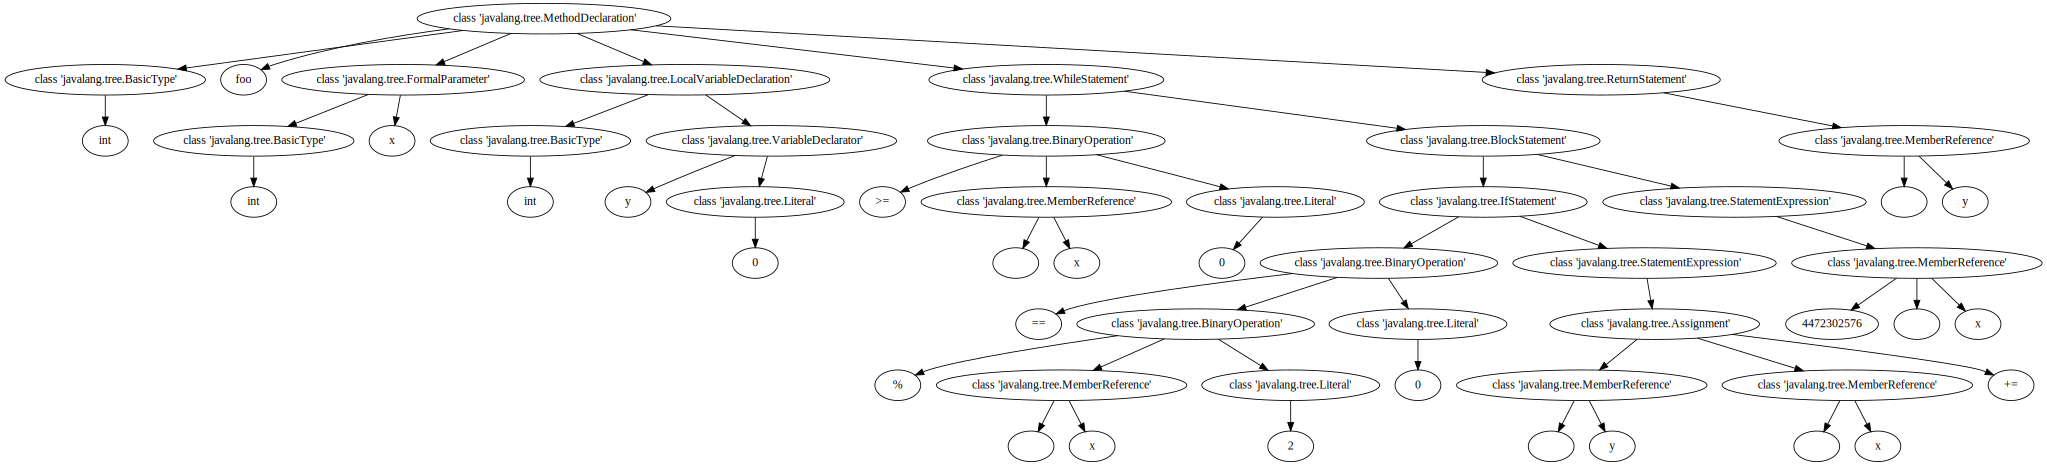

In [6]:
print_tree(tree)

## Control flow graph

The Control Flow Graph (CFG) models the flow of control in a program. A CFG is a directed graph $G = (N, E)$ where nodes $N$ correspond to _statements_ in the program, and edges $E$ represent where the control can flow. AST nodes that are children of statements (e.g. parameters) are not included in the CFG. (You are familiar with the relevant types of nodes since these are the roots of the statement trees you're extracting as part of the first assignment). By definition, our CFG will always contains two dedicated nodes representing an entry and exit node.

For reasons of convenience, we'll be using an existing graph library that provides some of the infrastructure we need when applying algorithms on the graph. The library we'll be using is [NetworkX](https://networkx.org/).

In [7]:
import networkx as nx

One of the reasons we're using NetworkX is that it can render graphs directly in our Jupyter notebook.

The first thing we need to do is define a class that represents a node in the CFG. We will store the AST node representing the statement as an attribute of a CFG node (could also use the statement tree), and add some code to produce readable labels for the CFG nodes.

In [8]:
class CFGNode:
    def __init__(self, ast_node):
        self.ast_node = ast_node
    
    def __str__(self):
        if type(self.ast_node) == str:
            return self.ast_node
        return str(self.ast_node.position.line - 1)

A control flow graph consists of a graph and dedicated start and end nodes. Since we are also going to create other graphs besides the CFG, which will only differ in the edges they contain, we define a general helper class `ProgramGraph` together with some wrapper functions to access the underlying NetworkX graph datastructure.

In [9]:
class ProgramGraph:
    def __init__(self, graph, start, end):
        self.graph = graph
        self.start = start
        self.end   = end
        
    def nodes(self):
        return self.graph.nodes()
    
    def edges(self):
        return self.graph.edges()
    
    def successors(self, node):
        return self.graph.successors(node)
    
    def predecessors(self, node):
        return self.graph.predecessors(node)
    
    def is_branch(self, node):
        return self.graph.out_degree(node) > 1
    
    def is_merge(self, node):
        return self.graph.in_degree(node) > 1
    
    def plot(self):
        pos = nx.nx_agraph.graphviz_layout(self.graph, prog="dot")
        nx.draw_networkx_nodes(self.graph, pos=pos, node_size=800, node_color='#FFFFFF', edgecolors='#000000')
        nx.draw_networkx_edges(self.graph, pos=pos, connectionstyle="arc", arrowsize=20)
        nx.draw_networkx_labels(self.graph, pos=pos)

The process of building a CFG consists of traversing the nodes of the AST, and creating CFG nodes whenever we encounter statements, as well as the relevant edges where we need them. We'll create a class `CFGBuilder` that helps us construct a CFG.

In [10]:
class CFGBuilder:
    def __init__(self, method_declaration):
        # create graph
        self.graph = nx.DiGraph()
        
        # create entry/end node
        self.start = CFGNode("Start")
        self.end   = CFGNode("End")
        self.graph.add_node(self.start)
        self.graph.add_node(self.end)
        
        # set entry as current target
        self.frontier = [ self.start ]
        
        for node in method_declaration.body:
            self.add_node(node)
            
        # Add edges from last nodes to end node
        for parent in self.frontier:
            self.graph.add_edge(parent, self.end)

    def create_graph(self):
        return ProgramGraph(self.graph, self.start, self.end)
    
    def add_node(self, node):
        # TODO: implement
        pass 

We now just need to fill the method `add_node` with content. For sequential control flow, edges are added simply between successor statements.

In [11]:
code = """
  public void foo(int x) {
    int y = x + 1;
    System.out.println("y = " + y);
  }
"""

Let's extend the `CFGBuilder` to handle this case.

In [12]:
class CFGBuilder(CFGBuilder):

    def add_node(self, node):
        cfg_node = CFGNode(node)
        self.graph.add_node(cfg_node)
        for parent in self.frontier:
            self.graph.add_edge(parent, cfg_node)
        self.frontier = [ cfg_node ]

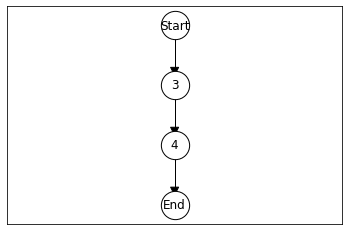

In [13]:
tree = parse_method(code)
cfg = CFGBuilder(tree).create_graph()
cfg.plot()

Code isn't always sequential, so we need to consider different types of programming constructs that we might encounter; for example, we might encounter `BlockStatements`: A block statement is a single node in the AST, but it contains children as subnodes. If we don't treat blocks special, we will only get a single node in the CFG.

In [14]:
code = """
  public void foo(int x) {
    {
      int y = x + 1;
      System.out.println("y = " + y);
    }
  }
"""

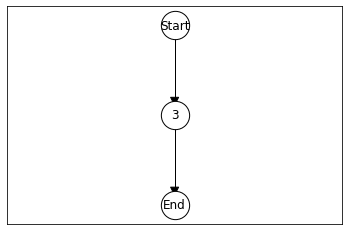

In [15]:
tree = parse_method(code)
cfg = CFGBuilder(tree).create_graph()
cfg.plot()

To fix this issue, we need to override our `add_node` method to handle block statements differently. 

In [16]:
class CFGBuilder(CFGBuilder):
    def add_block_node(self, block_node):
        for node in block_node.statements:
            self.add_node(node)            

    def add_statement_node(self, node):
        cfg_node = CFGNode(node)
        self.graph.add_node(cfg_node)
        for parent in self.frontier:
            self.graph.add_edge(parent, cfg_node)
        self.frontier = [ cfg_node ]           

    def add_node(self, node):
        if type(node) == javalang.tree.StatementExpression or type(node) == javalang.tree.LocalVariableDeclaration:
            self.add_statement_node(node)            
        elif type(node) == javalang.tree.BlockStatement:
            self.add_block_node(node)

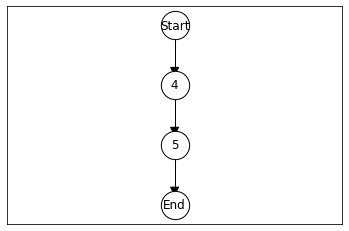

In [17]:
tree = parse_method(code)
cfg = CFGBuilder(tree).create_graph()
cfg.plot()

As you can imagine, we will need to extend the `add_node` function to delegate for all possible types of AST nodes. To avoid creating a large if-else construct, and because javalang does not provide a visitor interface, we'll use Python's single dispatch to create overloaded methods.

In [18]:
from functools import singledispatchmethod

In [19]:
class CFGBuilder(CFGBuilder):
    @singledispatchmethod
    def add_node(self, node):
        pass # Ignore, but could also throw NotImplementedError
    
    @add_node.register        
    def add_block_node(self, block_node: javalang.tree.BlockStatement):
        for node in block_node.statements:
            self.add_node(node)            
    
    @add_node.register
    def add_statement_node(self, node: javalang.tree.StatementExpression):
        cfg_node = CFGNode(node)
        self.graph.add_node(cfg_node)
        for parent in self.frontier:
            self.graph.add_edge(parent, cfg_node)
        self.frontier = [ cfg_node ]
        
    @add_node.register
    def add_declaration_node(self, node: javalang.tree.LocalVariableDeclaration):
        self.add_statement_node(node)

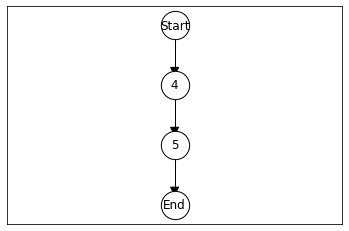

In [20]:
tree = parse_method(code)
cfg = CFGBuilder(tree).create_graph()
cfg.plot()

Next let's consider branching statements.

In [21]:
code = """
  public void foo(int x) {
    {
      int y = x + 1;
      if (y == 42) {
          System.out.println("y = the answer");
      }
    }
  }
"""

Our CFG builder doesn't know about branching yet, so it will treat an if statement like an individual statement.

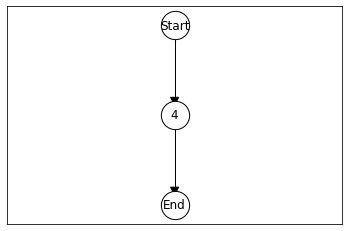

In [22]:
tree = parse_method(code)
cfg = CFGBuilder(tree).create_graph()
cfg.plot()

Thus, we need to add a method that handles if nodes. Whenever we add such a new method, the Python single dispatch requires us to also add the `add_node` method again, so expect to see this again and again (but still better adding new branches to a large if-construct, I think).

In [23]:
class CFGBuilder(CFGBuilder):
    
    @singledispatchmethod
    def add_node(cls, arg):
        super().add_node(arg)
    
    @add_node.register
    def add_if_node(self, if_node: javalang.tree.IfStatement):
        cfg_node = CFGNode(if_node)
        self.graph.add_node(cfg_node)

        for parent in self.frontier:
            self.graph.add_edge(parent, cfg_node)
        self.frontier = [cfg_node]
        self.add_node(if_node.then_statement)
        
        if if_node.else_statement:
            current_frontier = self.frontier[:]
            self.frontier = [cfg_node]
            self.add_node(if_node.else_statement)
            self.frontier.extend(current_frontier)
        else:
            self.frontier.append(cfg_node)


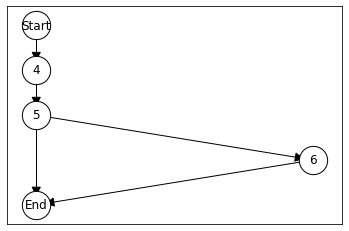

In [24]:
tree = parse_method(code)
cfg = CFGBuilder(tree).create_graph()
cfg.plot()

Let's also consider the case where there is an else-branch.

In [25]:
code = """
  public void foo(int x) {
    {
      if (y == 42) {
          System.out.println("y = the answer");
      } else {
          y = 3;
      }
    }
  }
"""

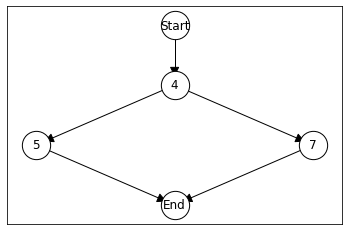

In [26]:
tree = parse_method(code)
cfg = CFGBuilder(tree).create_graph()
cfg.plot()

Next up, while loops.

In [27]:
code = """
  public void foo(int x) {
     int y = 0;
     while (y < x) {
       System.out.println("Hallo");
       y += 1;
     }
  }
"""

In [28]:
class CFGBuilder(CFGBuilder):

    @singledispatchmethod
    def add_node(cls, arg):
        super().add_node(arg)
    
    @add_node.register
    def add_while_node(self, while_node: javalang.tree.WhileStatement):
        cfg_node = CFGNode(while_node)
        self.graph.add_node(cfg_node)
        for parent in self.frontier:
            self.graph.add_edge(parent, cfg_node)
        self.frontier = [cfg_node]
        self.add_node(while_node.body)
        for parent in self.frontier:
            self.graph.add_edge(parent, cfg_node)
        self.frontier = [cfg_node]

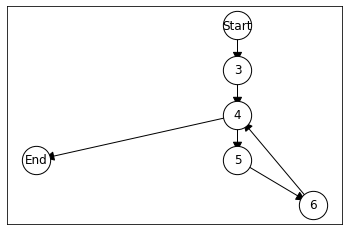

In [29]:
tree = parse_method(code)
cfg = CFGBuilder(tree).create_graph()
cfg.plot()

Do-while loops.

In [30]:
code = """
  public void foo(int x) {
     int y = 0;
     do {
       System.out.println("Hallo");
       y += 1;
     } while (y < x);
  }
"""

In [31]:
class CFGBuilder(CFGBuilder):

    @singledispatchmethod
    def add_node(cls, arg):
        super().add_node(arg)
    
    @add_node.register
    def add_do_node(self, do_node:javalang.tree.DoStatement):

        top = self.frontier[0]
        self.add_node(do_node.body)
        
        cfg_node = CFGNode(do_node)
        self.graph.add_node(cfg_node)
        for parent in self.frontier:
            self.graph.add_edge(parent, cfg_node)
        
        head = list(self.graph.successors(top))[0]
        self.graph.add_edge(cfg_node, head)
        self.frontier = [cfg_node]

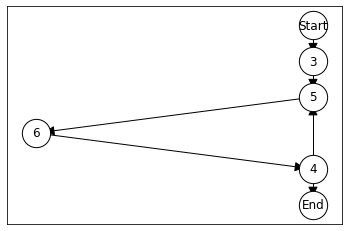

In [32]:
tree = parse_method(code)
cfg = CFGBuilder(tree).create_graph()
cfg.plot()

For `for`-loops we will not split up the loop header into three nodes (initialisation, condition, increment) to keep CFGs simple, but adding more nodes here would be straightforward.

In [33]:
code = """
  public void foo(int x) {
     for(int i = 0; i < 10; i++) {
       System.out.println("Hallo");
       System.out.println("Hallo");
     }
  }
"""

In [34]:
class CFGBuilder(CFGBuilder):
    @singledispatchmethod
    def add_node(cls, arg):
        super().add_node(arg)
    
    @add_node.register
    def add_for_node(self, for_node: javalang.tree.ForStatement):
        cfg_node = CFGNode(for_node)
        self.graph.add_node(cfg_node)
        for parent in self.frontier:
            self.graph.add_edge(parent, cfg_node)
        self.frontier = [ cfg_node ]
        self.add_node(for_node.body)
        for loop_end in self.frontier:
            self.graph.add_edge(loop_end, cfg_node)
        self.frontier = [ cfg_node ]   

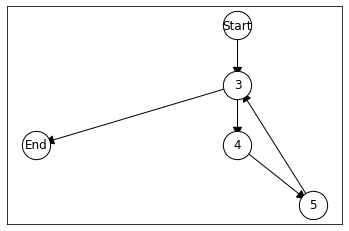

In [35]:
tree = parse_method(code)
cfg = CFGBuilder(tree).create_graph()
cfg.plot()

Return statements need to be linked directly to end.

In [36]:
code = """
  public boolean foo(int x) {
     if (x == 42) {
       return true;
     } else if (x == 0) {
       return false;
     }
     System.out.println("Hallo");
     return false;
  }
"""

In [37]:
class CFGBuilder(CFGBuilder):
    
    @singledispatchmethod
    def add_node(cls, arg):
        super().add_node(arg)
    
    @add_node.register
    def add_return_node(self, return_node: javalang.tree.ReturnStatement):
        cfg_node = CFGNode(return_node)
        self.graph.add_node(cfg_node)
        for parent in self.frontier:
            self.graph.add_edge(parent, cfg_node)
        self.graph.add_edge(cfg_node, self.end)
        self.frontier = []

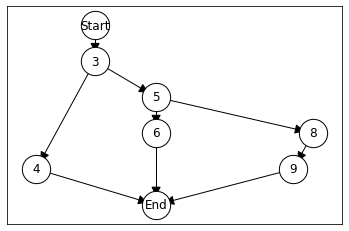

In [38]:
tree = parse_method(code)
cfg = CFGBuilder(tree).create_graph()
cfg.plot()

Switch-statements:

In [39]:
code = """
  public int foo(int x) {
     switch (x) {
       case 1:
         return true;
       case 2:
         return false;
       default:
         return false;
     }
  }
"""

In [40]:
class CFGBuilder(CFGBuilder):
    @singledispatchmethod
    def add_node(cls, arg):
        super().add_node(arg)
    
    @add_node.register
    def add_switch_node(self, switch_node: javalang.tree.SwitchStatement):
        cfg_node = CFGNode(switch_node)
        self.graph.add_node(cfg_node)
        for parent in self.frontier:
            self.graph.add_edge(parent, cfg_node)
        self.frontier = []
        break_cases = []
        for case in switch_node.cases:
            self.frontier.append(cfg_node)
            for statement in case.statements:
                self.add_node(statement)
            if isinstance(case.statements[-1], javalang.tree.BreakStatement):
                # If last statement is a break, add edge to the end
                break_cases.extend(self.frontier)
                self.frontier = []
        self.frontier.append(cfg_node)
        self.frontier.extend(break_cases)

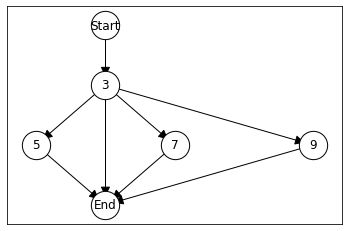

In [41]:
tree = parse_method(code)
cfg = CFGBuilder(tree).create_graph()
cfg.plot()

We can observe how the CFG differs depending on whether we forget (or purposely omit) a `break` statement in a switch-case.

In [42]:
code = """
  public int foo(int x) {
     switch (x) {
       case 1:
         System.out.println("Hallo");
         break;
       case 2:
         System.out.println("Hallo");
         break;
       case 3:
         System.out.println("Hallo");
         break;
     }
     return false;
  }
"""

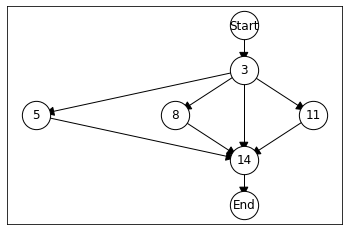

In [43]:
tree = parse_method(code)
cfg = CFGBuilder(tree).create_graph()
cfg.plot()

Here's the version with a missing `break`.

In [44]:
code = """
  public int foo(int x) {
     switch (x) {
       case 1:
         System.out.println("Hallo");
         break;
       case 2:
         System.out.println("Hallo");
         // Fall through
       case 3:
         System.out.println("Hallo");
         break;
     }
     return false;
  }
"""

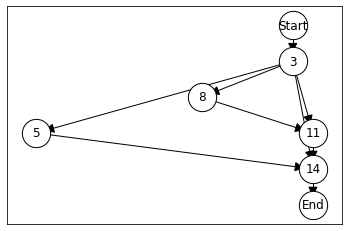

In [45]:
tree = parse_method(code)
cfg = CFGBuilder(tree).create_graph()
cfg.plot()

There are still several aspects of Java programs we have not covered yet, such as:
- `break` statements in loops
- `continue` statements
- `try`/`catch` statements
- Exceptional control flow
- `goto` statements

However, the functionality we have now is sufficient to cover the examples we need.

## Basic Blocks

A _basic block_ is a sequence of statements that must execute consecutively. Basic blocks can be used to reduce the number of nodes in a control flow graph. The control flow enters the first statement in the block and leaves the last statement, and no intermediate statements can exit the program or jump to another statement, thus we can generally also apply control flow analysis on basic blocks rather than individual statements.

In [46]:
from dataclasses import dataclass

class BasicBlock:
    def __init__(self):        
        self.cfg_nodes = []
        
    def __str__(self):
        return ",".join([str(node) for node in self.cfg_nodes])

The first step to create basic blocks is to identify _leaders_. The following nodes in the CFG are leaders:

- The entry node
- Every node that is the target of a branch
- Every node that is the target of an implicit goto (e.g., header of a while or for loop). We can identify these nodes because they will have more than one incoming edge.

In [47]:
def get_leaders(cfg):
    leaders = set()
    leaders.add(cfg.start)
    leaders.add(cfg.end) #todo: check
    
    for node in cfg.nodes():
        if cfg.is_branch(node):
            for successor in cfg.successors(node):
                leaders.add(successor)
        if cfg.is_merge(node):
            leaders.add(node)

    return leaders

Each leader starts a basic block that covers the sequence of nodes until the next leader. Thus, to calculate basic blocks we do a search starting from leader blocks up to the next leader blocks, and add all these blocks to our BasicBlock datastructure. We also maintain a mapping of CFG nodes to basic blocks, such that we can then connect the basic blocks with control flow edges.

In [48]:
def convert_bb(cfg):
    bbcfg = nx.DiGraph()
    
    leaders = get_leaders(cfg)
    bb_mapping = {}
    
    for leader in leaders:
        bb = BasicBlock()
        queue = [leader]
        while queue:
            element = queue.pop()
            if element not in bb.cfg_nodes and element not in queue:
                bb.cfg_nodes.append(element)
                bb_mapping[element] = bb
                
                if not cfg.is_branch(element):
                    for successor in cfg.successors(element):
                        if successor not in leaders:
                            queue.append(successor)
        bbcfg.add_node(bb)
    
    for s, t in cfg.edges():
        bbfrom = bb_mapping[s]
        bbto   = bb_mapping[t]
        if bbfrom != bbto:
            bbcfg.add_edge(bbfrom, bbto)

    return ProgramGraph(bbcfg, bb_mapping[cfg.start], bb_mapping[cfg.end])

Let's consider an example that contains some sequences of statements.

In [49]:
code = """
  public void foo(int x) {
     int y = 0;
     int z = x + 1;
     while (y < x) {
       System.out.println("Hallo");
       y += 1;
     }
  }
"""

First, here's the original CFG.

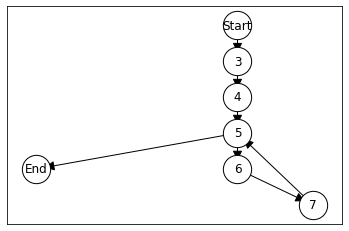

In [50]:
tree = parse_method(code)
cfg = CFGBuilder(tree).create_graph()
cfg.plot()

Here's the version with basic blocks.

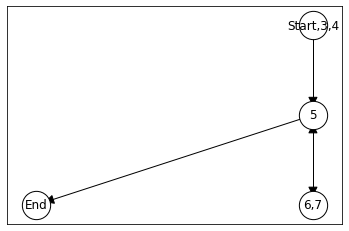

In [51]:
bbcfg = convert_bb(cfg)
bbcfg.plot()

Note that the two edges between node 5 and the merged node 6,7 overlap.

## Dominance

Node $a$ dominates node $b$ if every path from entry to $b$ must pass through $a$.

Node $a$ dominates $b$ if and only if:
- $a = b$ or
- $a$ is the unique predecessor to $b$ or
- $a$ is the unique predecessor to any of $b$’s predecessors.

In other words, the entry node dominates all other nodes; every node dominates itself; and the entry node to a loop dominates all other nodes in the loop.

The calculation of dominators is based on a fixpoint algorithm which updates a map $D$ of dominator nodes for each node in the CFG until no more changes are found:
1. We already know that the entry node will only be dominated by itself, so the map is initialised for entry accordingly.
2. For each other node the map is initialised with all other nodes to start with, and the sets are iteratively reduced.
3. In every iteration of the algorithm, the dominator set is updated for each node except the entry node. For node $n$ the set is updated to $n \cup (\bigcap D(p))$ for all immediate predecessors $p$ of n, where $D$ defines the currently stored for $p$.
4. If the dominator set for any of the nodes was changed, the algorithm repeats step 3. If no set was changed, a fixpoint has been reached.

In [52]:
class ProgramGraph(ProgramGraph):
    def dominators(self):
        entry = self.start
        remaining_nodes = [node for node in self.nodes() if node != entry]

        # D(entry) <- {entry}
        dominators = {}
        dominators[entry] = [entry]

        # D(node \ {entry}) <- nodes
        for node in remaining_nodes:
            dominators[node] = set(self.nodes())

        changed = True
        while changed:
            changed = False

            for node in remaining_nodes:
                current_dominators = dominators[node]

                # new_dominators = node \cup intersection(dominators for all predecessors)
                new_dominators = set(self.nodes())

                for p in self.predecessors(node):
                    new_dominators = new_dominators.intersection(dominators[p])

                new_dominators.add(node)

                if new_dominators.symmetric_difference(current_dominators):
                    dominators[node] = new_dominators
                    changed = True

        return dominators

Let's see this algorithm in action. First, here's the CFG that is the starting point.

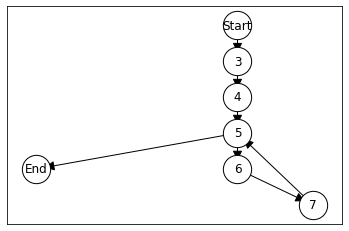

In [53]:
tree = parse_method(code)
cfg = CFGBuilder(tree).create_graph()
cfg.plot()

In [54]:
for node, dominators in cfg.dominators().items():
    dom = ",".join([str(d) for d in dominators])
    print(f"{node}: {dom}")

Start: Start
End: 5,End,Start,4,3
3: 3,Start
4: 4,3,Start
5: 4,3,5,Start
6: 6,5,Start,4,3
7: 5,7,3,Start,4,6


For example, the end node is not dominated by nodes 6 and 7, since there exists a path from start to end that does not include these two nodes.

The _strict_ dominators for a CFG node $n$ are all of its dominators except $n$ itself.

In [55]:
class ProgramGraph(ProgramGraph):
    def strict_dominators(self):
        dominators = self.dominators()
        for node, dom in dominators.items():
            dom.remove(node)
        return dominators

In [56]:
# Recreate CFG object since the method was added
cfg = CFGBuilder(tree).create_graph()

In [57]:
for node, dominators in cfg.strict_dominators().items():
    dom = ",".join([str(d) for d in dominators])
    print(f"{node}: {dom}")

Start: 
End: 4,5,Start,3
3: Start
4: 3,Start
5: 3,4,Start
6: 4,5,Start,3
7: 4,5,Start,6,3


The immediate dominator for a node $n$ is the last dominator of $n$ on any path from the entry to $n$. To calculate the immediate dominator for node $n$, we iterate over the strict dominators $s$ of $n$, and remove the dominators $D(s)$ from $D(n)$.

In [58]:
dominator_map = cfg.strict_dominators()
queue = [ cfg.start ]
while queue:
    current = queue.pop()
    for node in cfg.nodes():            
        dominators = dominator_map[node]
            
        if current in dominators:
            dominators.remove(current)
            if not dominators:
                print(f"Immediate dominator of {node}: {current}")
                queue.append(node)

Immediate dominator of 3: Start
Immediate dominator of 4: 3
Immediate dominator of 5: 4
Immediate dominator of End: 5
Immediate dominator of 6: 5
Immediate dominator of 7: 6


Given the dominance information, we can create the _dominator tree_, which is a graph (tree) that contains the same nodes as the CFG, but a node’s parent is its immediate dominator.

In [59]:
def dominator_tree(cfg):
    dt = nx.DiGraph()
    dt.add_nodes_from(cfg.nodes())
    dominator_map = cfg.strict_dominators()
    queue = [ cfg.start ]
    while queue:
        current = queue.pop()
        for node in cfg.nodes():            
            dominators = dominator_map[node]
            
            if current in dominators:
                dominators.remove(current)
                if not dominators:
                    dt.add_edge(current, node)
                    queue.append(node)

    return ProgramGraph(dt, cfg.start, cfg.end)

In [60]:
dt = dominator_tree(cfg)

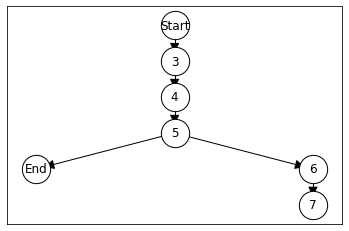

In [61]:
dt.plot()

## Post-Dominance

Node $b$ post-dominates $a$ if every path from $a$ to the exit node passes through $b$. The calculation of the post-dominance information uses the identical algorithm as the dominance calculation, except that, since the relation is inverted, the entire CFG is reversed before applying the algorithm. A graph is reversed by (1) inverting the direction of all its edges, and (2) swapping start and end nodes.

In [62]:
class ProgramGraph(ProgramGraph):
    def reverse(self):
        reverse_cfg = self.graph.reverse()
        return ProgramGraph(reverse_cfg, self.end, self.start)

Here's a simple example to invert.

In [63]:
code = """
  public boolean foo(int x) {
     if (x == 42) {
       return true;
     } else if (x == 0) {
       return false;
     }
     System.out.println("Hallo");
     return false;
  }
"""

First we consider the original CFG.

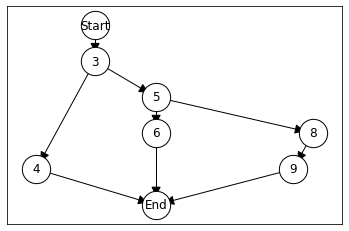

In [64]:
tree = parse_method(code)
cfg = CFGBuilder(tree).create_graph()
cfg.plot()

...and now the reversed CFG.

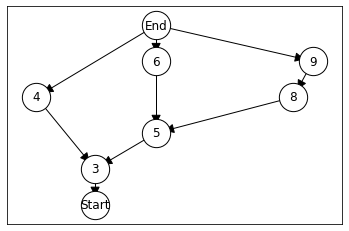

In [65]:
rcfg = cfg.reverse()
rcfg.plot()

The post-dominators can now be immediately calculated by reversing the CFG, and then calculating the dominators on the resulting reversed CFG.

In [66]:
class ProgramGraph(ProgramGraph):
    def post_dominators(self):
        rcfg = self.reverse()
        return rcfg.dominators()

In [67]:
cfg = CFGBuilder(tree).create_graph()

In [68]:
for node, postdominators in cfg.post_dominators().items():
    dom = ",".join([str(d) for d in postdominators])
    print(f"{node}: {dom}")

End: End
Start: 3,End,Start
3: 3,End
4: End,4
5: End,5
6: End,6
8: End,9,8
9: End,9


Similarly to the dominator tree, we can also define a postdominator-tree, in which each node has its immediate post-dominator as a parent.

In [69]:
def postdominator_tree(cfg):
    rcfg = cfg.reverse()
    return dominator_tree(rcfg)

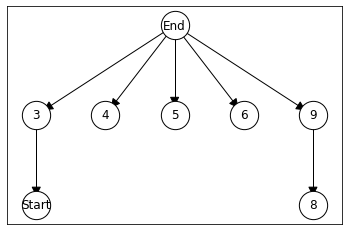

In [70]:
pdt = postdominator_tree(cfg)
pdt.plot()

## Control Dependence

Intuitively, a statement $b$ in the program is control dependent on statement $a$, if $a$ directly determines whether $b$ will be executed or not.

We define $b$ to be control dependent on $a$ if:
- There exists a directed path from $a$ to $b$ in the control flow graph where all nodes (excl. $a$) are post-dominated by $b$.
- $a$ is not post-dominated by $b$.
- For $b$ to be control dependent on $a$, $a$ must have two exits, one of which goes through $b$.

The algorithm to calculate control dependencies works as follows:

1. Create a new graph that contains the same node as the CFG (and DT and PDT).
2. Find $S$, a set of edges $(a,b)$ in the CFG such that $b$ is not an ancestor of $a$ in the post-dominator tree.
3. For each edge $(a,b) \in S$, find $L$, the least common ancestor $L$ of $a$ and $b$ in the post-dominator tree.
4. Consider each edge $(a,b) \in S$ and its corresponding $L$. Traverse backwards in the post-dominator tree from $b$ to $L$, marking each node visited; mark $L$ only if $L = a$.
5. Statements representing all marked nodes are control dependent on $a$; add edges to $a$ from all marked nodes.
6. All remaining nodes that are not connected in the end are only dependent on entry


We thus need a helper function that gives us the least common ancestor of two nodes in a graph.

In [71]:
class ProgramGraph(ProgramGraph):
    def transitive_successors(self, node):
        return nx.nodes(nx.dfs_tree(self.graph, node))
    
    def least_common_ancestor(self, node1, node2):
        current = node1
        successors = self.transitive_successors(current)

        while not (node1 in successors) or not (node2 in successors):
            current = list(self.graph.predecessors(current))[0]
            successors = self.transitive_successors(current)
        
        return current  

The first step of the algorithm requires a function to help us determine if one node is an ancestor of another node. We determine this using reachability.

In [72]:
class ProgramGraph(ProgramGraph):
    def is_reachable(self, source, target):
        successors = self.transitive_successors(source)
        return target in successors

Whenever we have found control dependencies we add edges, and in the end some nodes will not be connected since they are executed uncondintionally. To find these nodes, we can look for nodes without incoming edges.

In [73]:
class ProgramGraph(ProgramGraph):
    def in_degree(self, node):
        return self.graph.in_degree(node)

We will just connect all unconditionally executed nodes to the start node.

The actual algorithm just puts together these steps.

In [74]:
def control_dependence_graph(cfg):
    pdt = postdominator_tree(cfg)
    cdg = nx.DiGraph()
    cdg.add_nodes_from(cfg.nodes())
    
    # 1. Find S, a set of edges (a,b) in the CFG such that
    # b is not an ancestor of a in the post-dominator tree.
    edges = set()
    for a, b in cfg.edges():
        if not pdt.is_reachable(b, a):
            edges.add((a, b))

    for a, b in edges:
        # 2. For each edge (a,b) in S, find L, the least common ancestor
        # of a and b in the post-dominator tree.
        lca = pdt.least_common_ancestor(a, b)

        # Traverse backwards in the post-dominator tree from b to L,
        # marking each node visited; mark L only if L = a.
        # Statements representing all marked nodes are control dependent on a.
        current = b
        while current != lca:
            cdg.add_edge(a, current)
            current = list(pdt.predecessors(current))[0]

        if a == lca:
            cdg.add_edge(a, lca)

    # Any nodes not connected at this point are only dependent on entry
    entry = cfg.start
    for node in cdg.nodes():
        if node != entry and cdg.in_degree(node) == 0:
            cdg.add_edge(entry, node)

    return ProgramGraph(cdg, cfg.start, cfg.end)

We will now look at all the relevant intermediate graphs and the resulting control dependence graph.

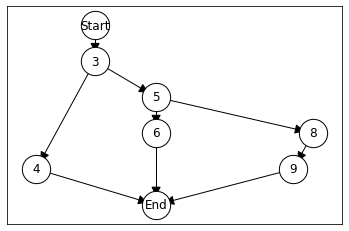

In [75]:
cfg = CFGBuilder(tree).create_graph()
cfg.plot()

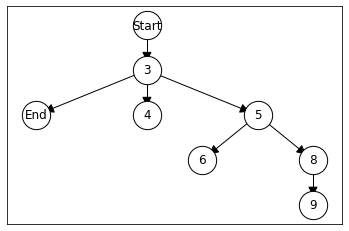

In [76]:
dt = dominator_tree(cfg)
dt.plot()

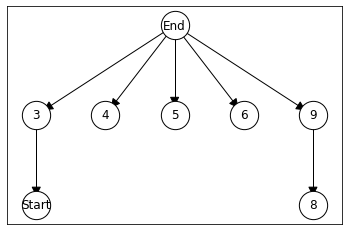

In [77]:
pdt = postdominator_tree(cfg)
pdt.plot()

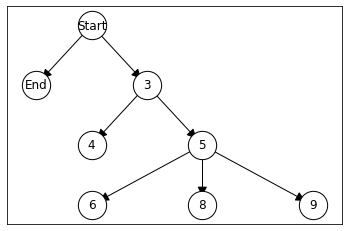

In [78]:
cdg = control_dependence_graph(cfg)
cdg.plot()

Finally, we consider a slightly trickier example which is also included on the lecture slides, to see that the control dependence graph is actually not a tree.

In [79]:
code = """
public boolean testMe(int x, int y) {
    if (x <= y) {
        if (x == y) {
            System.out.println("Some output");
        }
        if (x > 0) {
            if (y == 17) {
               return true;
            }
        }
    }
    return false;
}
"""

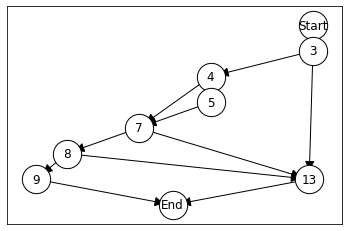

In [80]:
tree = parse_method(code)
cfg = CFGBuilder(tree).create_graph()
cfg.plot()

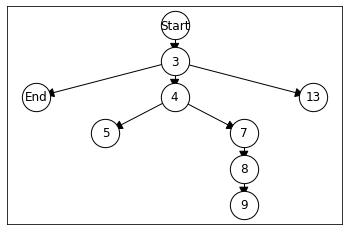

In [81]:
dt = dominator_tree(cfg)
dt.plot()

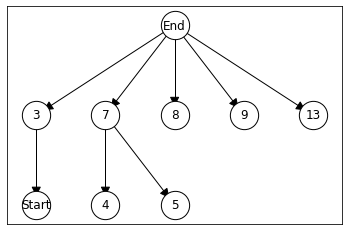

In [82]:
pdt = postdominator_tree(cfg)
pdt.plot()

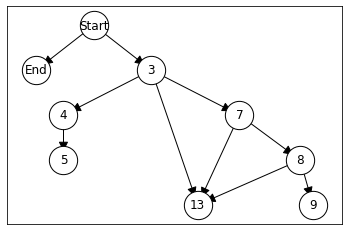

In [83]:
cdg = control_dependence_graph(cfg)
cdg.plot()